In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
 99% 1.61G/1.62G [00:20<00:00, 92.1MB/s]
100% 1.62G/1.62G [00:20<00:00, 83.4MB/s]


In [3]:
import zipfile
zip=zipfile.ZipFile('/content/ocular-disease-recognition-odir5k.zip')
zip.extractall('/content')
zip.close()

## Importing Libraries

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
df = pd.read_excel("/content/ODIR-5K/ODIR-5K/data.xlsx")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1


## Extracting Cataract & Normal information from the Dataset

In [6]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [7]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))


In [8]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]


array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [9]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [10]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))


Number of images in left cataract: 159
Number of images in right cataract: 154


In [11]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['264_right.jpg', '3258_right.jpg', '4276_right.jpg',
       '2615_right.jpg', '3230_right.jpg', '2518_right.jpg',
       '2989_right.jpg', '2889_right.jpg', '3135_right.jpg',
       '2833_right.jpg', '2437_right.jpg', '2501_right.jpg',
       '2915_right.jpg', '205_right.jpg', '2371_right.jpg'], dtype=object)

In [12]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)


In [13]:
print(len(cataract),len(normal))

313 500


## Creating Dataset from images

In [14]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/content/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue

        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)

    return dataset

In [15]:
import os
dataset = create_dataset(cataract,1)


100%|██████████| 313/313 [00:01<00:00, 279.06it/s]


In [16]:
len(dataset)

301

In [17]:
dataset = create_dataset(normal,0)


100%|██████████| 500/500 [00:01<00:00, 272.03it/s]


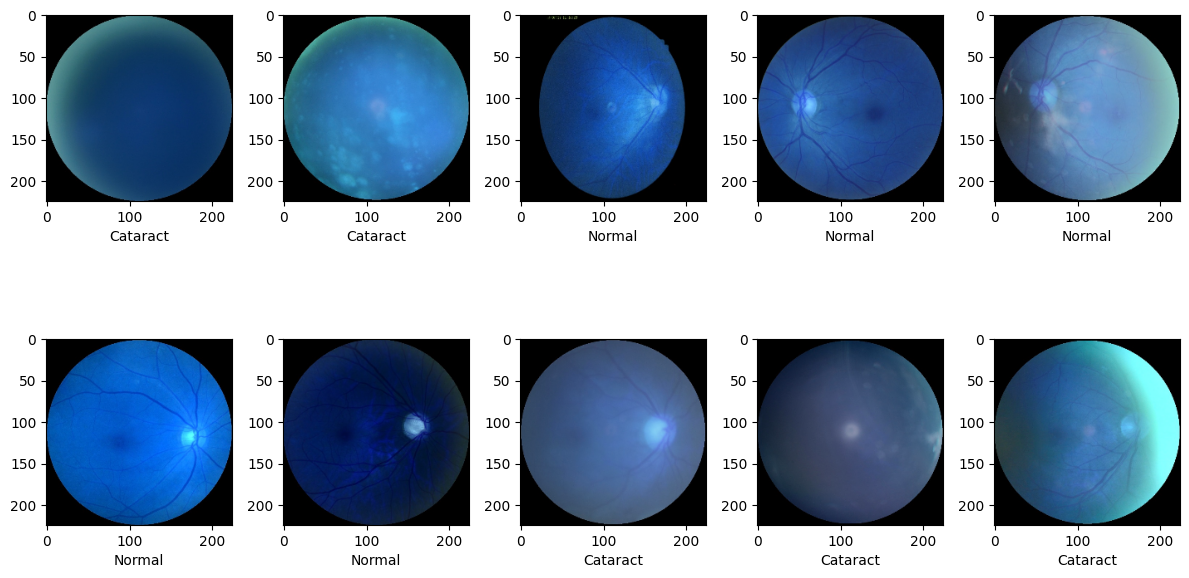

In [18]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

## Dividing dataset into x(features) & y(target)

In [19]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [20]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

## Creating Model

In [21]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 [==============================] - 1s 0us/step


In [22]:
for layer in vgg.layers:
    layer.trainable = False

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [25]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [27]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
20/20 [==============================] - ETA: 0s - loss: 1.1806 - accuracy: 0.8797

20/20 [==============================] - 14s 257ms/step - loss: 1.1806 - accuracy: 0.8797 - val_loss: 0.8054 - val_accuracy: 0.9441
Epoch 2/15
20/20 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.9641

20/20 [==============================] - 3s 171ms/step - loss: 0.4131 - accuracy: 0.9641 - val_loss: 0.4394 - val_accuracy: 0.9503
Epoch 3/15
20/20 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9781

20/20 [==============================] - 3s 172ms/step - loss: 0.1684 - accuracy: 0.9781 - val_loss: 0.6261 - val_accuracy: 0.9503
Epoch 4/15
20/20 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9797

20/20 [==============================] - 4s 202ms/step - loss: 0.1142 - accuracy: 0.9797 - val_loss: 0.6521 - val_accuracy: 0.9503
Epoch 5/15
20/20 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9906

20/20 [==============================] - 4s 205ms/step - loss: 0.0658 - accuracy: 0.9906 - val_loss: 0.5475 - val_accuracy: 0.9565
Epoch 6/15
20/20 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9969

20/20 [==============================] - 4s 203ms/step - loss: 0.0078 - accuracy: 0.9969 - val_loss: 0.4550 - val_accuracy: 0.9503
Epoch 7/15
20/20 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9984

20/20 [==============================] - 3s 172ms/step - loss: 0.0021 - accuracy: 0.9984 - val_loss: 0.4285 - val_accuracy: 0.9565
Epoch 8/15
20/20 [==============================] - ETA: 0s - loss: 1.7792e-04 - accuracy: 1.0000

20/20 [==============================] - 3s 175ms/step - loss: 1.7792e-04 - accuracy: 1.0000 - val_loss: 0.4489 - val_accuracy: 0.9627
Epoch 9/15
20/20 [==============================] - ETA: 0s - loss: 3.2766e-05 - accuracy: 1.0000

20/20 [==============================] - 3s 177ms/step - loss: 3.2766e-05 - accuracy: 1.0000 - val_loss: 0.4433 - val_accuracy: 0.9627
Epoch 10/15
20/20 [==============================] - ETA: 0s - loss: 1.9172e-05 - accuracy: 1.0000

20/20 [==============================] - 4s 205ms/step - loss: 1.9172e-05 - accuracy: 1.0000 - val_loss: 0.4413 - val_accuracy: 0.9565
Epoch 11/15
20/20 [==============================] - ETA: 0s - loss: 1.6493e-05 - accuracy: 1.0000

20/20 [==============================] - 4s 205ms/step - loss: 1.6493e-05 - accuracy: 1.0000 - val_loss: 0.4401 - val_accuracy: 0.9565
Epoch 12/15
20/20 [==============================] - ETA: 0s - loss: 1.4001e-05 - accuracy: 1.0000

20/20 [==============================] - 4s 178ms/step - loss: 1.4001e-05 - accuracy: 1.0000 - val_loss: 0.4394 - val_accuracy: 0.9565
Epoch 13/15
20/20 [==============================] - ETA: 0s - loss: 1.2879e-05 - accuracy: 1.0000

20/20 [==============================] - 4s 208ms/step - loss: 1.2879e-05 - accuracy: 1.0000 - val_loss: 0.4387 - val_accuracy: 0.9565
Epoch 14/15
20/20 [==============================] - ETA: 0s - loss: 1.2023e-05 - accuracy: 1.0000

20/20 [==============================] - 4s 207ms/step - loss: 1.2023e-05 - accuracy: 1.0000 - val_loss: 0.4378 - val_accuracy: 0.9565
Epoch 15/15
20/20 [==============================] - ETA: 0s - loss: 1.1127e-05 - accuracy: 1.0000

20/20 [==============================] - 4s 207ms/step - loss: 1.1127e-05 - accuracy: 1.0000 - val_loss: 0.4372 - val_accuracy: 0.9565


In [28]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

6/6 [==============================] - 1s 118ms/step - loss: 0.4372 - accuracy: 0.9565
loss: 0.437196284532547
Accuracy: 0.95652174949646


In [32]:
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict(x_test)
predicted_classes = np.argmax(y_pred, axis=1)

6/6 [==============================] - 1s 145ms/step


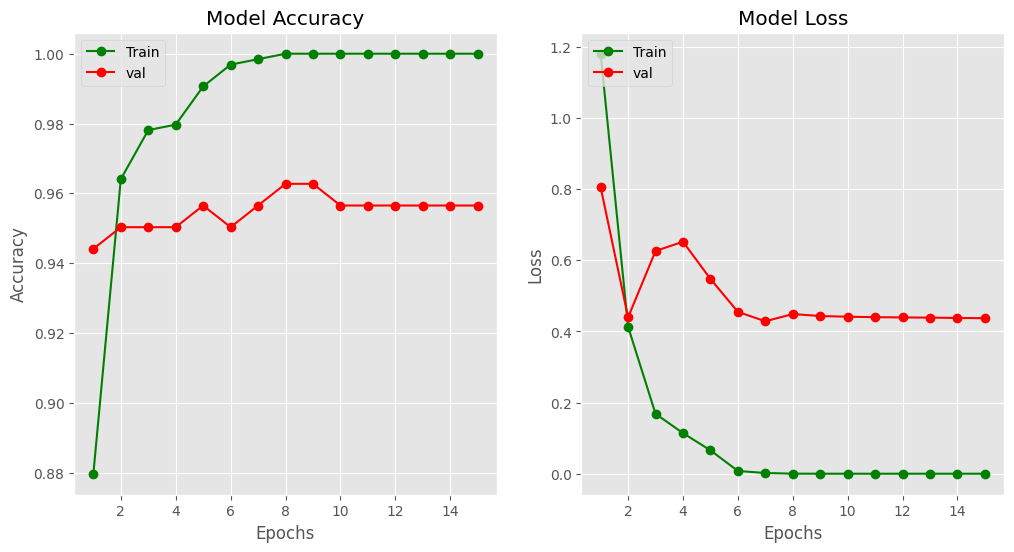

In [36]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()


## Prediction

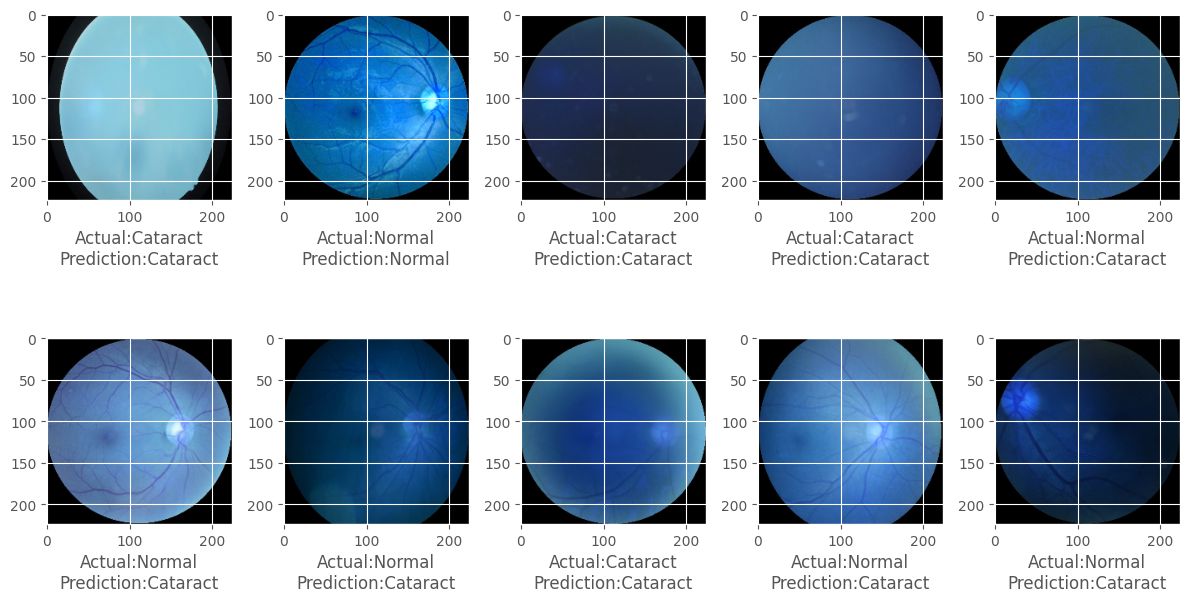

In [37]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()